In [1]:
#%% Import Moduels

## System Tools
import os
import sys
import numpy as np
## I/O Tools
import _pickle as pickle
## Data Process Tools
import pandas as pd
import datetime
## Graphs
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as figpdf
import matplotlib.dates as matdates
## Statistical Tools
import statsmodels.api as sm
import scipy.stats as stats
## Database API
from fredapi import Fred
## API for WRDS
import wrds

# End of Section: Import Moduels
###############################################################################


#%% Setup Working Directory
## Windows System Path
FolderList = [xx+"\\Dropbox\\Research Projects\\02_FirmHete_AsymmetricInformation\\Data\\Micro_data\\codes\\" \
              for xx in ["D:\\", "E:\\","B:\\","/mnt/b/"]]
for Folder in FolderList:
    if os.path.exists(Folder):
        os.chdir(Folder)     

## Output Folder
OutputFolder = '../results/AbReturnCyclicality/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
# End of Section: Setup Working Directory
###############################################################################
    

# End of Section: Setup Working Directory
###############################################################################


#%% Import Self-written Functions
CodeFolder      =   "../../../../../Code/PythonLib/"

sys.path.append(CodeFolder)

import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR
# End of Section: Import Self-written Functions
###############################################################################




# Construct the sample

## Load in the data

In [2]:
DataFolder          =   "..\\temp\\"
SDC_AbRet_Wide      =   pd.read_pickle(DataFolder+"SDC_AbRet_Wide.p")
SDC_IssuanceInfo    =   pd.read_pickle(DataFolder+"SDC_IssuanceInfo.p") 

In [3]:
VarList_AbRet = ['F_AccAbRet_-1_1', 'I_AccAbRet_-1_1']

temp = SDC_AbRet_Wide.loc[:, ['IssueID']+VarList_AbRet]
temp[VarList_AbRet] = temp[VarList_AbRet]*100

In [4]:
Sample = SDC_IssuanceInfo.merge(temp, how='left', left_on='IssueID', right_on='IssueID')

## Clean the data

In [5]:
# Measure the price drop differently for firms with different shelf-issuance type 
TempInd = Sample['ShelfIssueFlag']==1

Sample['EventDate'] = Sample['FilingDate']
Sample.loc[TempInd, 'EventDate'] = Sample.loc[TempInd, 'IssueDate']

Sample['AccAbRet'] = Sample['F_AccAbRet_-1_1']
Sample.loc[TempInd, 'AccAbRet'] = Sample.loc[TempInd, 'I_AccAbRet_-1_1']

Sample['EventDate_Quarter'] = Sample['FilingDate_Quarter']
Sample.loc[TempInd, 'EventDate_Quarter'] = Sample.loc[TempInd, 'IssueDate_Quarter']

In [6]:
# Different measures of issuance 
Sample['LogProceeds'] = np.log(Sample['ProceedsAmount'])
Sample['Proceed_Asset'] = Sample['ProceedsAmount'] / Sample['TotalAsset_BeforeOffering']
Sample['Proceed_Equity'] = Sample['ProceedsAmount'] / Sample['TotalEquity']
Sample['Log_Asset'] = np.log(Sample['TotalAsset_BeforeOffering'])
Sample['Leverage'] = Sample['TotalDebt'] / Sample['TotalAsset_BeforeOffering']
Sample['ExtraShare'] = Sample['OfferedTotalShares']/Sample['TotalShares_BeforeOffering']

d:\Dropbox\Research Projects\02_HeteFirm_AsymetricInformation\Data\Env_Python\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# Add the recession indicator
NBER_recessions = [
    (datetime.date(1980, 1, 1), datetime.date(1980, 7, 1)),
    (datetime.date(1981, 7, 1), datetime.date(1982, 11, 1)),
    (datetime.date(1990, 7, 1), datetime.date(1991, 3, 1)),
    (datetime.date(2001, 3, 1), datetime.date(2001, 11, 1)),
    (datetime.date(2007, 12, 1), datetime.date(2009, 6, 1)),
    # Add more recession periods as needed
]

def is_during_nber_recession(date):
    """
    Check if a given date falls within any NBER recession period.
'
    Parameters:
    date (datetime.date): The date to check.

    Returns:
    bool: True if the date is during an NBER recession, False otherwise.
    """
    for start, end in NBER_recessions:
        if start <= date <= end:
            return True
    return False

Sample['EventDate_RecFlag'] = Sample['EventDate'].apply(lambda x: is_during_nber_recession(x)*1 if pd.isna(x)==False else np.nan)

## Clean the Sample

### Clean by date and missing values

In [13]:
TempInd_Date = (Sample['EventDate_Quarter'] > datetime.date(1985, 1, 1) ) & (Sample['EventDate_Quarter'] < datetime.date(2019, 1, 1))
TempInd_NaN = np.isfinite(Sample[['Proceed_Asset', 'AccAbRet', 'LogProceeds', 'ExtraShare']]).all(axis=1)

In [14]:
Sample = Sample.loc[TempInd_Date & TempInd_NaN, :]

### Clean by outliers

In [15]:
VarList = ['Proceed_Asset', 'Proceed_Equity', 'ExtraShare', 'AccAbRet']
PctList = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]

In [16]:
DescStat = Sample[VarList].describe(percentiles=PctList)
DescStat 

,Proceed_Asset,Proceed_Equity,ExtraShare,AccAbRet
count,5597.000000,4365.000000,5597.000000,5597.000000
mean,0.575320,0.485224,11.343494,-2.774354
std,2.993605,1.885823,766.634168,9.473765
min,0.000021,-39.675000,0.000000,-75.747999
0.1%,0.003429,-17.997145,0.000828,-65.301775
0.5%,0.008528,-4.033793,0.006092,-41.920261
1%,0.014253,-1.763302,0.012341,-34.217373
5%,0.036668,0.056348,0.037279,-16.532933
10%,0.054268,0.106071,0.057224,-11.580740
25%,0.114017,0.222416,0.093317,-6.414504


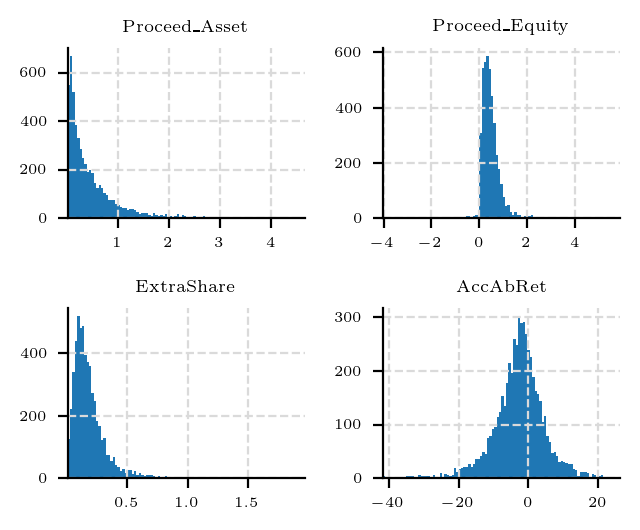

In [17]:
Fig = MyGR.Setup_Fig(FigSize=(1/5 * 2, 1/6 * 2))
for (ii, vv) in enumerate(VarList):
    ax = Fig.add_subplot(2,2,ii+1)
    tempind = (Sample[vv]>DescStat.loc['0.5%', vv]) & (Sample[vv]<DescStat.loc['99.5%', vv])
    Sample.loc[tempind, vv].hist(ax=ax, bins=100)
    ax.set_title(vv, fontsize=6)
    ax.set_xlim(DescStat.loc['0.5%', vv], DescStat.loc['99.5%', vv])
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    MyGR.Setup_Ax(ax)

plt.tight_layout()

In [18]:
Flag_Start = True
for vv in VarList:
    if Flag_Start:
        Flag_Start = False
        TempInd_Outliner = (Sample[vv]<DescStat.loc['0.5%', vv]) | (Sample[vv]>DescStat.loc['99.5%', vv])
    else:
        TempInd_Outliner = TempInd_Outliner | (Sample[vv]<DescStat.loc['0.5%', vv]) | (Sample[vv]>DescStat.loc['99.5%', vv])


In [19]:
tempind = (~TempInd_Outliner) & (Sample['ShareType']=='Primary')

In [20]:
Sample = Sample.loc[tempind, :]

# Unconditional business cycle property

## Time-series plot 

In [ ]:
def TempFun_WM(DS,VarList,WeightVar):
    Temp_Num        =   DS[VarList].multiply(DS[WeightVar],axis=0).sum(axis=0)
    Temp_DeNum      =   ( ~pd.isna(DS[VarList]) ).multiply(DS[WeightVar],axis=0).sum(axis=0)
    WM              =   Temp_Num.divide(Temp_DeNum,axis=0)
    WM.name         =   'WMean'
    
    return WM



In [23]:
DataForPlot = pd.concat([Sample.groupby('EventDate_Quarter')['AccAbRet'].mean().sort_index().rename('AccAbRet_Avg'), \
                         Sample.groupby('EventDate_Quarter').apply(TempFun_WM, ['AccAbRet'], 'ExtraShare', include_groups=False).sort_index()['AccAbRet'].rename('AccAbRet_WAvg')], \
                        axis=1).sort_index()

In [24]:
# Export the aggregate data 
temp = pd.read_pickle('../../Macro_data/temp/AggDS_Dict_AggPQ.p')

temp['Level'][['GDP', 'PCE', 'PDI', 'PDI_NonRes']].to_csv(OutputFolder+'GFC_CaseStudy_Data_Agg.csv')

In [25]:
# Add the aggregate price and quantity data
temp = pd.read_pickle('../../Macro_data/temp/AggDS_Dict_AggPQ.p')

DataForPlot = DataForPlot.merge(temp['Detrend'][['Growth_GDP', 'GDP']], left_index=True, right_index=True, how='left')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


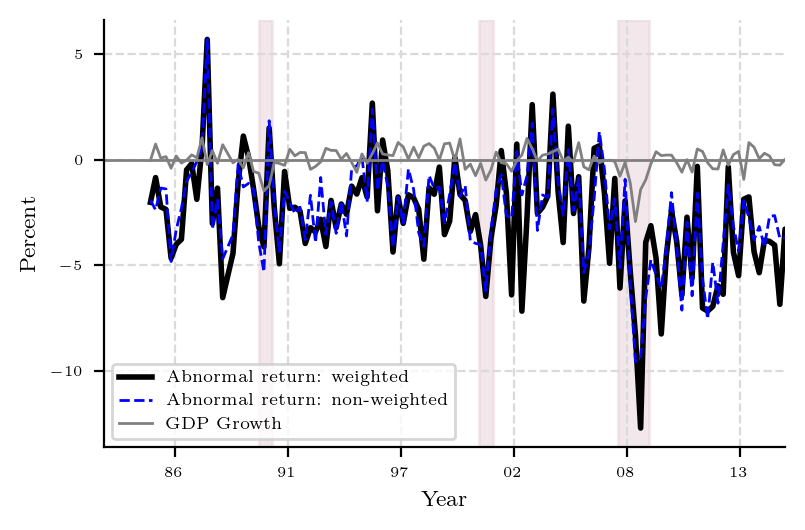

In [26]:
Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=2).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg'], ax=ax, Label="Abnormal return: weighted")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_Avg'], ax=ax, Label="Abnormal return: non-weighted")
MyGR.Line(Color="Gray", Style="solid", Width=1).Plot(DataForPlot.index, DataForPlot['Growth_GDP'], ax=ax, Label="GDP Growth")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'AccAbRet_BusinessCycle.eps', format='eps', dpi=1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


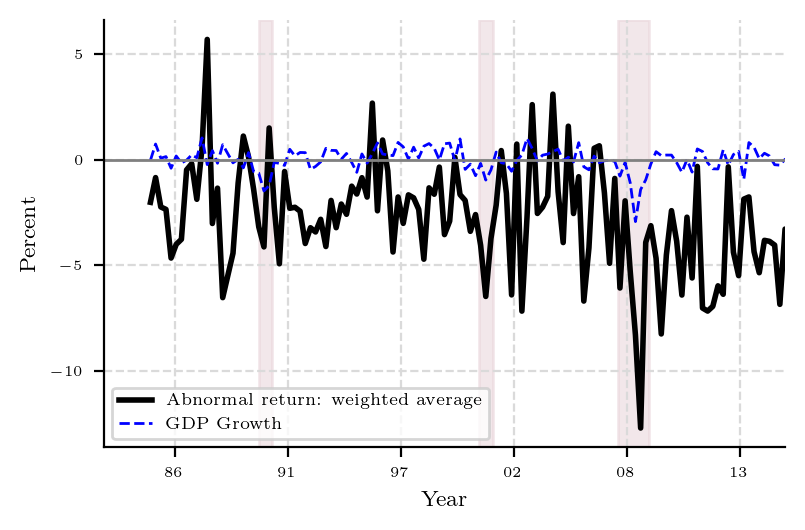

In [31]:
Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=2).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg'], ax=ax, Label="Abnormal return: weighted average")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['Growth_GDP'], ax=ax, Label="GDP Growth")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'AccAbRet_BusinessCycle_OnlyWAvg.eps', format='eps', dpi=1000)

In [47]:
non_nan_index = DataForPlot.dropna().index
TempIndex = non_nan_index[(non_nan_index>=datetime.datetime(1983,1,1)) & (non_nan_index<=datetime.datetime(2018,12,31))] 

DataForPlot.loc[TempIndex, :].mean()

AccAbRet_Avg    -2.765506
AccAbRet_WAvg   -3.045448
Growth_GDP       0.015216
GDP              2.451418
dtype: float64

In [48]:
DataForPlot.loc[TempIndex, :].describe()

,AccAbRet_Avg,AccAbRet_WAvg,Growth_GDP,GDP
count,132.000000,132.000000,132.000000,132.000000
mean,-2.765506,-3.045448,0.015216,2.451418
std,2.405061,2.782080,0.546700,4.347166
min,-9.572133,-12.711328,-2.932082,-5.285307
25%,-4.041655,-4.396807,-0.197301,-1.154437
50%,-2.635023,-2.721793,0.039028,2.380259
75%,-1.332501,-1.589818,0.348227,6.489941
max,5.697731,5.697731,1.033272,9.933585


In [49]:
DataForPlot.loc[TempIndex, 'AccAbRet_WAvg'].autocorr()

np.float64(0.3070318362420049)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


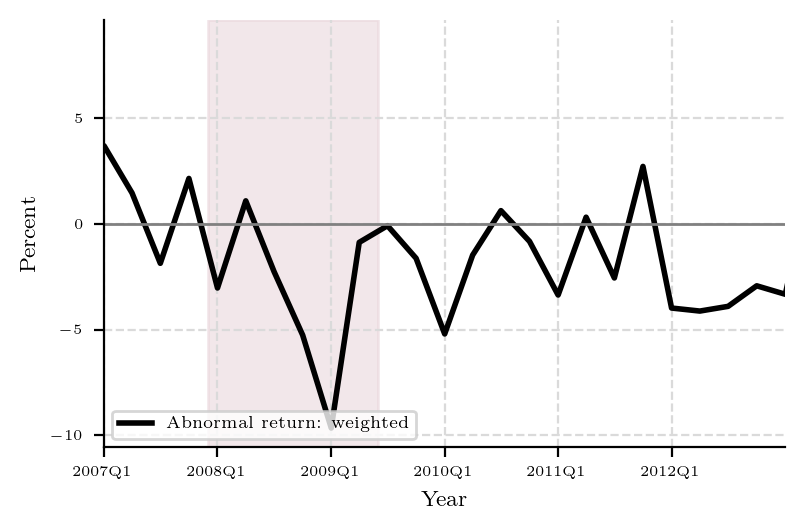

In [50]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=2).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg'] - DataForPlot.loc[TempIndex, 'AccAbRet_WAvg'].mean(), ax=ax, Label="Abnormal return: weighted")

ax.set_xlim([datetime.date(2007,1,1),datetime.date(2012,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=7)

def quarter_format(x, pos):
    dt = mdates.num2date(x)  # Convert to datetime
    quarter = (dt.month - 1) // 3 + 1
    return f"{dt.year}Q{quarter}"
ax.set_xticks([datetime.datetime(yy,1,1) for yy in range(2007,2013, 1)])
ax.xaxis.set_major_formatter(FuncFormatter(quarter_format))
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'GFC_CaseStudy_Data_AccAbRet.eps', format='eps', dpi=1000)

In [53]:
(DataForPlot['AccAbRet_WAvg'] - DataForPlot.loc[TempIndex, 'AccAbRet_WAvg'].mean()).to_excel(OutputFolder+'GFC_CaseStudy_Data_AccAbRet.xlsx')

In [36]:
temp = non_nan_index[(non_nan_index>=datetime.datetime(2007,1,1)) & (non_nan_index<=datetime.datetime(2010,12,31))] 
DataForPlot.loc[temp, 'AccAbRet_WAvg'] - DataForPlot.loc[TempIndex, 'AccAbRet_WAvg'].mean()

EventDate_Quarter
2007-01-01    3.704914
2007-04-01    1.469681
2007-07-01   -1.862391
2007-10-01    2.157769
2008-01-01   -3.032579
2008-04-01    1.096867
2008-07-01   -2.255870
2008-10-01   -5.262130
2009-01-01   -9.665881
2009-04-01   -0.871589
2009-07-01   -0.080256
2009-10-01   -1.624396
2010-01-01   -5.208417
2010-04-01   -1.472609
2010-07-01    0.632546
2010-10-01   -0.824214
Name: AccAbRet_WAvg, dtype: float64

## Correlation with GDP growth

In [37]:
non_nan_index = DataForPlot.dropna().index
TempIndex = non_nan_index[(non_nan_index>=datetime.datetime(1983,1,1)) & (non_nan_index<=datetime.datetime(2015,12,31))] 

TempVarList = ['AccAbRet_Avg', 'AccAbRet_WAvg']

TempTab = pd.concat([pd.Series(stats.pearsonr(DataForPlot.loc[TempIndex, vv], DataForPlot.loc[TempIndex, 'Growth_GDP']), index=['Corr', 'p-value']) for vv in TempVarList], axis=1, keys=TempVarList)

TempTab.to_latex(OutputFolder+'Corr_w_GDPGrowth.tex', float_format="%.3g", escape=True)

TempTab 

,AccAbRet_Avg,AccAbRet_WAvg
Corr,0.394736,0.302356
p-value,0.000007,0.000712


In [38]:
DataForPlot.loc[TempIndex, :].std()

AccAbRet_Avg     2.299566
AccAbRet_WAvg    2.619573
Growth_GDP       0.564669
GDP              3.952681
dtype: float64

## Recession vs. Non-Recession

In [43]:
TempIndex = (Sample['EventDate']>=datetime.date(1985,1,1)) & (Sample['EventDate']<=datetime.date(2015,12,31))
TempTab = Sample.loc[TempIndex, :].groupby('EventDate_RecFlag')['AccAbRet'].describe()

TempTab.to_latex(OutputFolder+'AccAbRet_RecessionVsNonRecession.tex', float_format="%.3g", escape=True)

TempTab 

,count,mean,std,min,25%,50%,75%,max
EventDate_RecFlag,,,,,,,,
0.0,2503.0,-2.541168,8.015156,-41.918162,-6.170095,-2.137066,1.947259,25.457379
1.0,155.0,-4.672199,9.480287,-35.956782,-9.964711,-4.330052,0.729778,26.100980


In [44]:
# T-Test of the Abnormal Returns in recessions and non-recessions
group1 = Sample.loc[TempIndex & (Sample['EventDate_RecFlag']==1), 'AccAbRet']
group2 = Sample.loc[TempIndex & (Sample['EventDate_RecFlag']==0), 'AccAbRet']

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(group1.dropna(), group2.dropna())
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.175632224174105, P-value: 0.0015122342067841934
